# Deep Q-Network (DQN)
---
implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

1) explore the environment

2) build replay buffer

3) build Q network

4) build agent (warp the network and other functions in it)

5) train agent


In [1]:
import gym
import random
import numpy as np
from collections import namedtuple, deque
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

from DQN_agent import *

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### (1/5) Explore the environment

Initialize the environment in the code cell below.

In [3]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)

State shape:  (8,)
Number of actions:  4


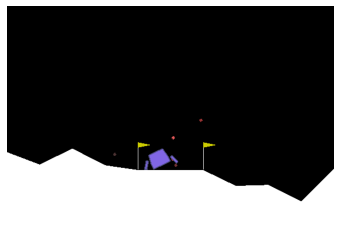

In [5]:
img = plt.imshow(env.render(mode='rgb_array'))
state = env.reset()
for j in range(200):
    action = env.action_space.sample() 
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 
env.close()

### (2/5) Replay buffer

In [6]:
buffer = deque(maxlen = 500)  
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
state = env.reset()
for j in range(200):
    action = env.action_space.sample() 
    next_state, reward, done, _ = env.step(action)
    buffer.append(experience(state, action, reward, next_state, done))
    state = next_state
    if done:
        break 
env.close()

In [38]:
buffer = ReplayBuffer(buffer_size = 500)

state = env.reset()
for j in range(200):
    action = env.action_space.sample() 
    next_state, reward, done, _ = env.step(action)
    buffer.push(state, action, reward, next_state, done)
    state = next_state
    if done:
        break 
env.close()

In [41]:
states, actions, rewards, next_states, dones = buffer.sample(16)
print(states.size())
print(actions.size())
print(rewards.size())
print(dones.size())

torch.Size([16, 8])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])


### (3/5) Q network

In [13]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.main = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, action_size)
        )
        
    def forward(self, state):
        x = self.main(state)
        return x

In [212]:
net = QNetwork(STATE_SIZE, ACTION_SIZE, 16,1234).to(device)

### (4/5) Build agent

wrap:

1) act: select action according to policy derived from online network

2) learn: take a GD step

3) soft_update: update target network

4) step: (overall control)add tuple to replay buffer, sample a batch from buffer to learn (call learn)



In [14]:
class Agent():
    def __init__(self, state_size, action_size, hidden_size, seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.seed = seed
        
        self.online_net = QNetwork(state_size, action_size, hidden_size, seed).to(device)
        self.target_net = QNetwork(state_size, action_size, hidden_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.online_net.parameters(), lr = LR)
        self.memory = ReplayBuffer(buffer_size = BUFFER_SIZE)
        self.t_step = 1 # tracking whether to update target network parameters
        
    def act(self, state, eps = 0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # select action according to online network
        self.online_net.eval()
        with torch.no_grad():
            action = self.online_net(state_tensor).argmax(1).item()
        self.online_net.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return action
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        loss_fn = nn.MSELoss()

        next_Q = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target = rewards + gamma*next_Q*(1-dones)
        
        prediction = self.online_net(states).gather(1, actions)
        
        loss = loss_fn(prediction, target.detach())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def soft_update(self, tau):
        for target_param, online_param in zip(self.target_net.parameters(), self.online_net.parameters()):
            target_param.data.copy_(tau*target_param.data + (1.0-tau)*online_param.data)
        
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = self.t_step + 1
        # sample batch and learn
        if len(self.memory)> BATCH_SIZE: 
            experiences = self.memory.sample(BATCH_SIZE)
            self.learn(experiences, GAMMA)
            # update target network
            if (self.t_step % UPDATE_EVERY) == 0:
                self.soft_update(TAU)
            
        

In [15]:
# test agent
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.999             # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 5        # how often to update the target network

agent = Agent(STATE_SIZE, ACTION_SIZE, 16,1234)
state = env.reset()
agent.act(state)

In [17]:
state = env.reset()
for j in range(200):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    if done:
        break 
env.close()

In [45]:
torch.from_numpy(state).float().unsqueeze(1).size()

torch.Size([8, 1])

### (5/5) train agent

put all the pieces together, and start training

In [22]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.999             # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 5        # how often to update the target network
TMAX = 1000             # maximum steps per episode

n_episodes = 800
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

PRINT_EVERY = 50

agent = Agent(STATE_SIZE, ACTION_SIZE, 64,1234)

In [23]:
scores = []; score_window = deque(maxlen = PRINT_EVERY)                        
eps = eps_start                    
hold_mean = 0.0

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(TMAX):
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
            
    scores.append(score)    
    score_window.append(score)
    mean_score = np.mean(score_window)
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score), end="")
    if i_episode % PRINT_EVERY == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode,mean_score))
        if mean_score >=hold_mean:
            print('\nmodel saved!')
            torch.save(agent.online_net.state_dict(), 'checkpoint.pth')
            hold_mean = mean_score

Episode 50	Average Score: -168.80
Episode 100	Average Score: -158.12
Episode 150	Average Score: -129.27
Episode 200	Average Score: -125.41
Episode 250	Average Score: -65.981
Episode 300	Average Score: -46.32
Episode 350	Average Score: -4.891
Episode 400	Average Score: 65.48

model saved!
Episode 450	Average Score: 88.86

model saved!
Episode 500	Average Score: 119.60

model saved!
Episode 550	Average Score: 175.23

model saved!
Episode 600	Average Score: 208.80

model saved!
Episode 650	Average Score: 235.50

model saved!
Episode 700	Average Score: 228.81
Episode 750	Average Score: 235.66

model saved!
Episode 800	Average Score: 249.11

model saved!


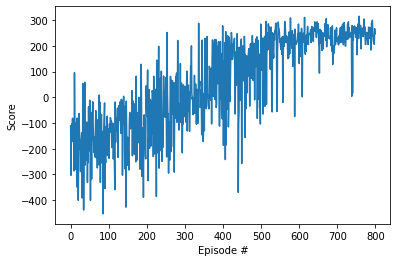

In [24]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

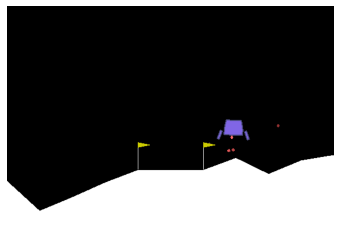

In [26]:
# watch agent
agent = Agent(STATE_SIZE, ACTION_SIZE, 64,1234)
agent.online_net.load_state_dict(torch.load('checkpoint.pth'))


for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()